In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Sequential, losses, optimizers
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_recall_curve
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_recall_curve
from sklearn.model_selection import KFold,StratifiedKFold

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [28]:
def build_network():
    os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\based_model\5k\Acet_CNN_OH')
    cnn = load_model('dataoh.h5')
    cnn.trainable = True #固定所有预训练模型层的参数
    base_model = Model(inputs=cnn.layers[0].input,outputs=cnn.layers[8].output)
    base_model.summary()
    base_model.trainable = True
    for layer in base_model.layers[:0]:
        layer.trainable = False
    Dense = tf.keras.layers.Dense(64,activation=tf.nn.relu)
    global_average_layer = tf.keras.layers.GlobalAveragePooling1D()
    prediction_layer = tf.keras.layers.Dense(1,activation=tf.nn.sigmoid)
    model1 = tf.keras.Sequential([
        base_model,
        #layers.Conv1D(filters=128, kernel_size=3, padding='same', activation=tf.nn.relu),
        #layers.Dropout(0.5),
        Dense,
        layers.Dropout(0.5),
        global_average_layer,
        prediction_layer
    ])
    base_learning_rate = 0.002
    model1.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate), loss='binary_crossentropy',metrics=['accuracy'])#编译模型
    #model1.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    model1.summary()
    return model1

In [29]:
def One_hot_raw(path):
    seqs = open(path).readlines()

    X1 = [seq.split()[1] for seq in seqs if seq.strip() != '']
    y = [int(seq.split()[0]) for seq in seqs if seq.strip() != '']
    One = []
    for i in range(0, len(X1)):
        One.append(list(X1[i]))
    X = pd.DataFrame(One)
    return np.array(X), np.array(y)


def one_hot(rawDataFrame, codingMode=0):  # rawDataFrame is numpy.ndarray

    sampleSeq3DArr = rawDataFrame[:, :]

    if codingMode == 0:
        probMatr = convertSampleToProbMatr(sampleSeq3DArr)

    return probMatr


def convertSampleToProbMatr(sampleSeq3DArr):  # changed add one column for '1'

    letterDict = {"A": 0, "C": 1, "D": 2, "E": 3, "F": 4, "G": 5, "H": 6, "I": 7, "K": 8, "L": 9, "M": 10, "N": 11,
                  "P": 12, "Q": 13, "R": 14, "S": 15, "T": 16, "V": 17, "W": 18, "Y": 19, "X": 20}
    AACategoryLen = 21  # add -

    probMatr = np.zeros((len(sampleSeq3DArr), 1, len(sampleSeq3DArr[0]), AACategoryLen))

    sampleNo = 0
    for sequence in sampleSeq3DArr:

        AANo = 0
        for AA in sequence:

            if not AA in letterDict:
                probMatr[sampleNo][0][AANo] = np.full((1, AACategoryLen), 1.0 / AACategoryLen)

            else:
                index = letterDict[AA]
                probMatr[sampleNo][0][AANo][index] = 1

            AANo += 1
        sampleNo += 1

    return probMatr

In [30]:
def preprocess(x, y):
    x = tf.cast(x, dtype=tf.float32)
    y = tf.cast(y, dtype=tf.int32)
    return x, y

In [35]:
batch_size=256

In [36]:
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\data\NEDD\迁移数据\训练集')
epochs = 300
x_train,y_train = One_hot_raw('train.txt')#十折交叉验证10
x_test,y_test = One_hot_raw('test.txt')#独立测试1

In [37]:
classes = sorted(list(set(y_train)))
x_train = one_hot(x_train)
x_test = one_hot(x_test)
x_train.shape = (x_train.shape[0],x_train.shape[2],x_train.shape[3])
x_test.shape = (x_test.shape[0],x_test.shape[2],x_test.shape[3])

In [38]:
# 构建独立测试集对象，预处理，批量化
test_db = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_db = test_db.map(preprocess).batch(batch_size)

In [39]:
prediction_result_cv = []
prediction_result_ind = []

In [40]:
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet\base_data_NEDD_Acet\data_5k')

In [41]:
out = os.getcwd() + '\\'

In [42]:
from sklearn.model_selection import KFold,StratifiedKFold
kf = StratifiedKFold(n_splits=10,shuffle=True)
for n_fold,(tr_idx,val_idx)in enumerate(kf.split(x_train,y_train)):
    tr_x,tr_y,val_x,val_y = x_train[tr_idx],y_train[tr_idx],x_train[val_idx],y_train[val_idx]
    # 构建训练集对象，随机打乱，预处理，批量化
    train_db = tf.data.Dataset.from_tensor_slices((tr_x, tr_y))
    train_db = train_db.shuffle(len(tr_x)).map(preprocess).batch(batch_size)
    # 构建测试集对象，预处理，批量化
    valid_db = tf.data.Dataset.from_tensor_slices((val_x, val_y))
    valid_db = valid_db.map(preprocess).batch(batch_size)
    #if not os.path.exists('%s_%d.h5' % (out, n_fold)):
    model1 = build_network()
    best_saving = tf.keras.callbacks.ModelCheckpoint(filepath='%s_%d.h5' % (out, n_fold), monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=False)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
    history = model1.fit(train_db, epochs=epochs, validation_data=valid_db, verbose=2,callbacks=[best_saving, early_stopping], batch_size=batch_size)
    #network.load_weights('%s_%d.h5' % (out, n_fold))
    #history = network.fit(train_db, epochs=50, validation_data=valid_db, verbose=2)
    scores1 = model1.predict(val_x, batch_size=batch_size)[:, 0]
    score_val = pd.DataFrame(scores1)
    y_val = pd.DataFrame(val_y)
    datav=pd.concat([score_val,y_val],axis=1)
    print(n_fold + 1) 
    n_fold_str = str(n_fold + 1)
    pathv ='val_out'+ n_fold_str
    datav.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet\base_data_NEDD_Acet\data_5k\result\val\\'+pathv+'.csv',encoding='utf-8')
    datav.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet\base_data_NEDD_Acet\data_5k\result\valtxt\\'+pathv+'.txt',sep='\t',index=False,encoding='utf-8')
    scores2 = model1.predict(x_test, batch_size=batch_size)[:, 0]
    score_indep = pd.DataFrame(scores2)
    test_y = pd.DataFrame(y_test)
    datai = pd.concat([score_indep,test_y],axis=1)
    pathi ='indep_out'+ n_fold_str
    datai.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet\base_data_NEDD_Acet\data_5k\result\indep\\'+pathi+'.csv',encoding='utf-8')
    datai.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet\base_data_NEDD_Acet\data_5k\result\indeptxt\\'+pathi+'.txt',sep='\t',index=False,encoding='utf-8')

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_input (InputLayer)    [(None, 41, 21)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 41, 128)           2816      
_________________________________________________________________
dropout (Dropout)            (None, 41, 128)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 20, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 128)           49280     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 128)           0  


Epoch 00029: val_loss did not improve from 0.55785
Epoch 30/300
8/8 - 0s - loss: 0.5374 - accuracy: 0.7385 - val_loss: 0.5961 - val_accuracy: 0.6933

Epoch 00030: val_loss did not improve from 0.55785
Epoch 31/300
8/8 - 0s - loss: 0.4578 - accuracy: 0.7771 - val_loss: 0.5699 - val_accuracy: 0.7022

Epoch 00031: val_loss did not improve from 0.55785
Epoch 32/300
8/8 - 0s - loss: 0.4723 - accuracy: 0.7662 - val_loss: 0.5953 - val_accuracy: 0.6400

Epoch 00032: val_loss did not improve from 0.55785
Epoch 33/300
8/8 - 0s - loss: 0.4833 - accuracy: 0.7637 - val_loss: 0.5658 - val_accuracy: 0.7022

Epoch 00033: val_loss did not improve from 0.55785
Epoch 34/300
8/8 - 0s - loss: 0.4795 - accuracy: 0.7726 - val_loss: 0.5849 - val_accuracy: 0.6844

Epoch 00034: val_loss did not improve from 0.55785
Epoch 35/300
8/8 - 0s - loss: 0.4579 - accuracy: 0.7840 - val_loss: 0.5714 - val_accuracy: 0.6889

Epoch 00035: val_loss did not improve from 0.55785
Epoch 36/300
8/8 - 0s - loss: 0.4297 - accuracy:


Epoch 00082: val_loss did not improve from 0.54850
Epoch 83/300
8/8 - 0s - loss: 0.3179 - accuracy: 0.8591 - val_loss: 0.6183 - val_accuracy: 0.6844

Epoch 00083: val_loss did not improve from 0.54850
Epoch 84/300
8/8 - 0s - loss: 0.2693 - accuracy: 0.8873 - val_loss: 0.6866 - val_accuracy: 0.6356

Epoch 00084: val_loss did not improve from 0.54850
Epoch 85/300
8/8 - 0s - loss: 0.3165 - accuracy: 0.8646 - val_loss: 0.5764 - val_accuracy: 0.6933

Epoch 00085: val_loss did not improve from 0.54850
Epoch 86/300
8/8 - 0s - loss: 0.2786 - accuracy: 0.8814 - val_loss: 0.6076 - val_accuracy: 0.7067

Epoch 00086: val_loss did not improve from 0.54850
Epoch 87/300
8/8 - 0s - loss: 0.2558 - accuracy: 0.9016 - val_loss: 0.5872 - val_accuracy: 0.7067

Epoch 00087: val_loss did not improve from 0.54850
Epoch 88/300
8/8 - 0s - loss: 0.3070 - accuracy: 0.8670 - val_loss: 0.6375 - val_accuracy: 0.6667

Epoch 00088: val_loss did not improve from 0.54850
Epoch 89/300
8/8 - 0s - loss: 0.2636 - accuracy:

8/8 - 0s - loss: 0.5441 - accuracy: 0.7153 - val_loss: 0.5783 - val_accuracy: 0.6933

Epoch 00015: val_loss improved from 0.59036 to 0.57828, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet\base_data_NEDD_Acet\data_5k\_1.h5
Epoch 16/300
8/8 - 0s - loss: 0.5621 - accuracy: 0.7064 - val_loss: 0.5901 - val_accuracy: 0.6933

Epoch 00016: val_loss did not improve from 0.57828
Epoch 17/300
8/8 - 0s - loss: 0.5345 - accuracy: 0.7257 - val_loss: 0.5828 - val_accuracy: 0.6800

Epoch 00017: val_loss did not improve from 0.57828
Epoch 18/300
8/8 - 0s - loss: 0.5460 - accuracy: 0.7044 - val_loss: 0.5836 - val_accuracy: 0.6978

Epoch 00018: val_loss did not improve from 0.57828
Epoch 19/300
8/8 - 0s - loss: 0.5314 - accuracy: 0.7222 - val_loss: 0.5767 - val_accuracy: 0.6844

Epoch 00019: val_loss improved from 0.57828 to 0.57671, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet\base_data_NEDD_Ac

8/8 - 0s - loss: 0.3791 - accuracy: 0.8369 - val_loss: 0.5637 - val_accuracy: 0.6844

Epoch 00065: val_loss did not improve from 0.54476
Epoch 66/300
8/8 - 0s - loss: 0.3322 - accuracy: 0.8576 - val_loss: 0.5514 - val_accuracy: 0.7111

Epoch 00066: val_loss did not improve from 0.54476
Epoch 67/300
8/8 - 0s - loss: 0.3919 - accuracy: 0.8151 - val_loss: 0.5726 - val_accuracy: 0.7200

Epoch 00067: val_loss did not improve from 0.54476
Epoch 68/300
8/8 - 0s - loss: 0.3160 - accuracy: 0.8685 - val_loss: 0.5546 - val_accuracy: 0.7244

Epoch 00068: val_loss did not improve from 0.54476
Epoch 69/300
8/8 - 0s - loss: 0.3292 - accuracy: 0.8591 - val_loss: 0.5532 - val_accuracy: 0.6978

Epoch 00069: val_loss did not improve from 0.54476
Epoch 70/300
8/8 - 0s - loss: 0.3639 - accuracy: 0.8314 - val_loss: 0.5535 - val_accuracy: 0.6889

Epoch 00070: val_loss did not improve from 0.54476
Epoch 71/300
8/8 - 0s - loss: 0.3281 - accuracy: 0.8646 - val_loss: 0.6160 - val_accuracy: 0.6978

Epoch 00071: v


Epoch 00118: val_loss did not improve from 0.54393
Epoch 119/300
8/8 - 0s - loss: 0.2216 - accuracy: 0.9066 - val_loss: 0.5853 - val_accuracy: 0.7022

Epoch 00119: val_loss did not improve from 0.54393
Epoch 120/300
8/8 - 0s - loss: 0.2181 - accuracy: 0.9155 - val_loss: 0.5716 - val_accuracy: 0.6978

Epoch 00120: val_loss did not improve from 0.54393
Epoch 121/300
8/8 - 0s - loss: 0.1996 - accuracy: 0.9209 - val_loss: 0.5772 - val_accuracy: 0.7067

Epoch 00121: val_loss did not improve from 0.54393
Epoch 122/300
8/8 - 0s - loss: 0.2065 - accuracy: 0.9199 - val_loss: 0.5736 - val_accuracy: 0.7200

Epoch 00122: val_loss did not improve from 0.54393
Epoch 123/300
8/8 - 0s - loss: 0.2269 - accuracy: 0.9115 - val_loss: 0.6239 - val_accuracy: 0.6844

Epoch 00123: val_loss did not improve from 0.54393
Epoch 124/300
8/8 - 0s - loss: 0.2222 - accuracy: 0.9046 - val_loss: 0.5821 - val_accuracy: 0.7111

Epoch 00124: val_loss did not improve from 0.54393
Epoch 125/300
8/8 - 0s - loss: 0.1836 - ac

8/8 - 0s - loss: 0.5954 - accuracy: 0.6644 - val_loss: 0.6019 - val_accuracy: 0.6622

Epoch 00006: val_loss improved from 0.61327 to 0.60187, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet\base_data_NEDD_Acet\data_5k\_2.h5
Epoch 7/300
8/8 - 0s - loss: 0.5905 - accuracy: 0.6762 - val_loss: 0.6204 - val_accuracy: 0.6622

Epoch 00007: val_loss did not improve from 0.60187
Epoch 8/300
8/8 - 0s - loss: 0.6065 - accuracy: 0.6639 - val_loss: 0.6035 - val_accuracy: 0.6578

Epoch 00008: val_loss did not improve from 0.60187
Epoch 9/300
8/8 - 0s - loss: 0.5756 - accuracy: 0.6955 - val_loss: 0.5927 - val_accuracy: 0.6533

Epoch 00009: val_loss improved from 0.60187 to 0.59274, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet\base_data_NEDD_Acet\data_5k\_2.h5
Epoch 10/300
8/8 - 0s - loss: 0.5795 - accuracy: 0.6876 - val_loss: 0.6052 - val_accuracy: 0.6400

Epoch 00010: val_loss did not improve


Epoch 00052: val_loss did not improve from 0.52470
Epoch 53/300
8/8 - 0s - loss: 0.4024 - accuracy: 0.8082 - val_loss: 0.5444 - val_accuracy: 0.7467

Epoch 00053: val_loss did not improve from 0.52470
Epoch 54/300
8/8 - 0s - loss: 0.3779 - accuracy: 0.8349 - val_loss: 0.5467 - val_accuracy: 0.7244

Epoch 00054: val_loss did not improve from 0.52470
Epoch 55/300
8/8 - 0s - loss: 0.3840 - accuracy: 0.8216 - val_loss: 0.5516 - val_accuracy: 0.7422

Epoch 00055: val_loss did not improve from 0.52470
Epoch 56/300
8/8 - 0s - loss: 0.4007 - accuracy: 0.8072 - val_loss: 0.5735 - val_accuracy: 0.7467

Epoch 00056: val_loss did not improve from 0.52470
Epoch 57/300
8/8 - 0s - loss: 0.3565 - accuracy: 0.8334 - val_loss: 0.5650 - val_accuracy: 0.7556

Epoch 00057: val_loss did not improve from 0.52470
Epoch 58/300
8/8 - 0s - loss: 0.3786 - accuracy: 0.8295 - val_loss: 0.5481 - val_accuracy: 0.7333

Epoch 00058: val_loss did not improve from 0.52470
Epoch 59/300
8/8 - 0s - loss: 0.3409 - accuracy:

8/8 - 1s - loss: 0.6742 - accuracy: 0.5744 - val_loss: 0.6455 - val_accuracy: 0.6578

Epoch 00001: val_loss improved from inf to 0.64552, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet\base_data_NEDD_Acet\data_5k\_3.h5
Epoch 2/300
8/8 - 0s - loss: 0.6307 - accuracy: 0.6515 - val_loss: 0.6430 - val_accuracy: 0.6267

Epoch 00002: val_loss improved from 0.64552 to 0.64302, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet\base_data_NEDD_Acet\data_5k\_3.h5
Epoch 3/300
8/8 - 0s - loss: 0.6241 - accuracy: 0.6456 - val_loss: 0.6210 - val_accuracy: 0.6489

Epoch 00003: val_loss improved from 0.64302 to 0.62103, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet\base_data_NEDD_Acet\data_5k\_3.h5
Epoch 4/300
8/8 - 0s - loss: 0.6140 - accuracy: 0.6624 - val_loss: 0.6183 - val_accuracy: 0.6578

Epoch 00004: val_loss improved from 0.62103 to 0.61

8/8 - 0s - loss: 0.4272 - accuracy: 0.7998 - val_loss: 0.5749 - val_accuracy: 0.7111

Epoch 00043: val_loss did not improve from 0.56855
Epoch 44/300
8/8 - 0s - loss: 0.4332 - accuracy: 0.7958 - val_loss: 0.6906 - val_accuracy: 0.6267

Epoch 00044: val_loss did not improve from 0.56855
Epoch 45/300
8/8 - 0s - loss: 0.4470 - accuracy: 0.7919 - val_loss: 0.5727 - val_accuracy: 0.6978

Epoch 00045: val_loss did not improve from 0.56855
Epoch 46/300
8/8 - 0s - loss: 0.3927 - accuracy: 0.8201 - val_loss: 0.5938 - val_accuracy: 0.6756

Epoch 00046: val_loss did not improve from 0.56855
Epoch 47/300
8/8 - 0s - loss: 0.4354 - accuracy: 0.7805 - val_loss: 0.5998 - val_accuracy: 0.6978

Epoch 00047: val_loss did not improve from 0.56855
Epoch 48/300
8/8 - 0s - loss: 0.3843 - accuracy: 0.8295 - val_loss: 0.5798 - val_accuracy: 0.6756

Epoch 00048: val_loss did not improve from 0.56855
Epoch 49/300
8/8 - 0s - loss: 0.4241 - accuracy: 0.7944 - val_loss: 0.5714 - val_accuracy: 0.6844

Epoch 00049: v

8/8 - 0s - loss: 0.2561 - accuracy: 0.8927 - val_loss: 0.6150 - val_accuracy: 0.7022

Epoch 00097: val_loss did not improve from 0.56816
Epoch 98/300
8/8 - 0s - loss: 0.2312 - accuracy: 0.8997 - val_loss: 0.6210 - val_accuracy: 0.6889

Epoch 00098: val_loss did not improve from 0.56816
Epoch 99/300
8/8 - 0s - loss: 0.2898 - accuracy: 0.8809 - val_loss: 0.6042 - val_accuracy: 0.6711

Epoch 00099: val_loss did not improve from 0.56816
Epoch 100/300
8/8 - 0s - loss: 0.2316 - accuracy: 0.9006 - val_loss: 0.6742 - val_accuracy: 0.6978

Epoch 00100: val_loss did not improve from 0.56816
Epoch 101/300
8/8 - 0s - loss: 0.2293 - accuracy: 0.9026 - val_loss: 0.6260 - val_accuracy: 0.6844

Epoch 00101: val_loss did not improve from 0.56816
Epoch 102/300
8/8 - 0s - loss: 0.2163 - accuracy: 0.9155 - val_loss: 0.6605 - val_accuracy: 0.6844

Epoch 00102: val_loss did not improve from 0.56816
Epoch 103/300
8/8 - 0s - loss: 0.2114 - accuracy: 0.9170 - val_loss: 0.6538 - val_accuracy: 0.6889

Epoch 0010


Epoch 00013: val_loss did not improve from 0.59582
Epoch 14/300
8/8 - 0s - loss: 0.5343 - accuracy: 0.7182 - val_loss: 0.6054 - val_accuracy: 0.6267

Epoch 00014: val_loss did not improve from 0.59582
Epoch 15/300
8/8 - 0s - loss: 0.5511 - accuracy: 0.7054 - val_loss: 0.5922 - val_accuracy: 0.6978

Epoch 00015: val_loss improved from 0.59582 to 0.59221, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet\base_data_NEDD_Acet\data_5k\_4.h5
Epoch 16/300
8/8 - 0s - loss: 0.5409 - accuracy: 0.7257 - val_loss: 0.5926 - val_accuracy: 0.6844

Epoch 00016: val_loss did not improve from 0.59221
Epoch 17/300
8/8 - 0s - loss: 0.5295 - accuracy: 0.7247 - val_loss: 0.6097 - val_accuracy: 0.6267

Epoch 00017: val_loss did not improve from 0.59221
Epoch 18/300
8/8 - 0s - loss: 0.5309 - accuracy: 0.7316 - val_loss: 0.6005 - val_accuracy: 0.6356

Epoch 00018: val_loss did not improve from 0.59221
Epoch 19/300
8/8 - 0s - loss: 0.5189 - accuracy: 0.7266 - 

8/8 - 0s - loss: 0.3744 - accuracy: 0.8364 - val_loss: 0.6034 - val_accuracy: 0.6889

Epoch 00061: val_loss did not improve from 0.57088
Epoch 62/300
8/8 - 0s - loss: 0.3673 - accuracy: 0.8309 - val_loss: 0.5760 - val_accuracy: 0.6756

Epoch 00062: val_loss did not improve from 0.57088
Epoch 63/300
8/8 - 0s - loss: 0.3207 - accuracy: 0.8616 - val_loss: 0.5892 - val_accuracy: 0.6667

Epoch 00063: val_loss did not improve from 0.57088
Epoch 64/300
8/8 - 0s - loss: 0.3443 - accuracy: 0.8532 - val_loss: 0.6467 - val_accuracy: 0.6311

Epoch 00064: val_loss did not improve from 0.57088
Epoch 65/300
8/8 - 0s - loss: 0.3524 - accuracy: 0.8492 - val_loss: 0.6377 - val_accuracy: 0.6356

Epoch 00065: val_loss did not improve from 0.57088
Epoch 66/300
8/8 - 0s - loss: 0.3417 - accuracy: 0.8512 - val_loss: 0.6426 - val_accuracy: 0.6444

Epoch 00066: val_loss did not improve from 0.57088
Epoch 67/300
8/8 - 0s - loss: 0.3360 - accuracy: 0.8507 - val_loss: 0.6348 - val_accuracy: 0.6489

Epoch 00067: v

5
Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_input (InputLayer)    [(None, 41, 21)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 41, 128)           2816      
_________________________________________________________________
dropout (Dropout)            (None, 41, 128)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 20, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 128)           49280     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 128)           0


Epoch 00028: val_loss did not improve from 0.60213
Epoch 29/300
8/8 - 0s - loss: 0.4628 - accuracy: 0.7751 - val_loss: 0.6868 - val_accuracy: 0.5733

Epoch 00029: val_loss did not improve from 0.60213
Epoch 30/300
8/8 - 0s - loss: 0.4767 - accuracy: 0.7701 - val_loss: 0.6506 - val_accuracy: 0.6267

Epoch 00030: val_loss did not improve from 0.60213
Epoch 31/300
8/8 - 0s - loss: 0.4725 - accuracy: 0.7687 - val_loss: 0.6147 - val_accuracy: 0.6756

Epoch 00031: val_loss did not improve from 0.60213
Epoch 32/300
8/8 - 0s - loss: 0.4678 - accuracy: 0.7687 - val_loss: 0.6109 - val_accuracy: 0.6622

Epoch 00032: val_loss did not improve from 0.60213
Epoch 33/300
8/8 - 0s - loss: 0.4490 - accuracy: 0.7805 - val_loss: 0.6589 - val_accuracy: 0.6311

Epoch 00033: val_loss did not improve from 0.60213
Epoch 34/300
8/8 - 0s - loss: 0.4832 - accuracy: 0.7677 - val_loss: 0.6351 - val_accuracy: 0.6311

Epoch 00034: val_loss did not improve from 0.60213
Epoch 35/300
8/8 - 0s - loss: 0.4490 - accuracy:


Epoch 00082: val_loss did not improve from 0.58719
Epoch 83/300
8/8 - 0s - loss: 0.2843 - accuracy: 0.8814 - val_loss: 0.7048 - val_accuracy: 0.6267

Epoch 00083: val_loss did not improve from 0.58719
Epoch 84/300
8/8 - 0s - loss: 0.2778 - accuracy: 0.8819 - val_loss: 0.6249 - val_accuracy: 0.6667

Epoch 00084: val_loss did not improve from 0.58719
Epoch 85/300
8/8 - 0s - loss: 0.2952 - accuracy: 0.8749 - val_loss: 0.6497 - val_accuracy: 0.6356

Epoch 00085: val_loss did not improve from 0.58719
Epoch 86/300
8/8 - 0s - loss: 0.2464 - accuracy: 0.8992 - val_loss: 0.6821 - val_accuracy: 0.6444

Epoch 00086: val_loss did not improve from 0.58719
Epoch 87/300
8/8 - 0s - loss: 0.2670 - accuracy: 0.8917 - val_loss: 0.6607 - val_accuracy: 0.6800

Epoch 00087: val_loss did not improve from 0.58719
6
Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_input (InputLayer)    [(None, 41, 21)] 


Epoch 00017: val_loss improved from 0.56859 to 0.56290, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet\base_data_NEDD_Acet\data_5k\_6.h5
Epoch 18/300
8/8 - 0s - loss: 0.5375 - accuracy: 0.7350 - val_loss: 0.5609 - val_accuracy: 0.7556

Epoch 00018: val_loss improved from 0.56290 to 0.56094, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet\base_data_NEDD_Acet\data_5k\_6.h5
Epoch 19/300
8/8 - 0s - loss: 0.5438 - accuracy: 0.7276 - val_loss: 0.5706 - val_accuracy: 0.7422

Epoch 00019: val_loss did not improve from 0.56094
Epoch 20/300
8/8 - 0s - loss: 0.5070 - accuracy: 0.7449 - val_loss: 0.5503 - val_accuracy: 0.7333

Epoch 00020: val_loss improved from 0.56094 to 0.55027, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet\base_data_NEDD_Acet\data_5k\_6.h5
Epoch 21/300
8/8 - 0s - loss: 0.5344 - accuracy: 0.7177 - val_loss: 0.5563 - v

8/8 - 0s - loss: 0.3676 - accuracy: 0.8334 - val_loss: 0.5328 - val_accuracy: 0.7644

Epoch 00062: val_loss did not improve from 0.51140
Epoch 63/300
8/8 - 0s - loss: 0.3329 - accuracy: 0.8591 - val_loss: 0.5314 - val_accuracy: 0.7600

Epoch 00063: val_loss did not improve from 0.51140
Epoch 64/300
8/8 - 0s - loss: 0.3891 - accuracy: 0.8191 - val_loss: 0.5542 - val_accuracy: 0.7511

Epoch 00064: val_loss did not improve from 0.51140
Epoch 65/300
8/8 - 0s - loss: 0.3209 - accuracy: 0.8611 - val_loss: 0.5163 - val_accuracy: 0.7733

Epoch 00065: val_loss did not improve from 0.51140
Epoch 66/300
8/8 - 0s - loss: 0.3517 - accuracy: 0.8384 - val_loss: 0.5421 - val_accuracy: 0.7511

Epoch 00066: val_loss did not improve from 0.51140
Epoch 67/300
8/8 - 0s - loss: 0.3219 - accuracy: 0.8571 - val_loss: 0.5060 - val_accuracy: 0.7378

Epoch 00067: val_loss improved from 0.51140 to 0.50598, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet\base_da

8/8 - 0s - loss: 0.2285 - accuracy: 0.9090 - val_loss: 0.5148 - val_accuracy: 0.7511

Epoch 00116: val_loss did not improve from 0.50598
Epoch 117/300
8/8 - 0s - loss: 0.2083 - accuracy: 0.9214 - val_loss: 0.5867 - val_accuracy: 0.7244

Epoch 00117: val_loss did not improve from 0.50598
7
Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_input (InputLayer)    [(None, 41, 21)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 41, 128)           2816      
_________________________________________________________________
dropout (Dropout)            (None, 41, 128)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 20, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (No


Epoch 00023: val_loss did not improve from 0.54239
Epoch 24/300
8/8 - 0s - loss: 0.5281 - accuracy: 0.7321 - val_loss: 0.5551 - val_accuracy: 0.7156

Epoch 00024: val_loss did not improve from 0.54239
Epoch 25/300
8/8 - 0s - loss: 0.5051 - accuracy: 0.7469 - val_loss: 0.5640 - val_accuracy: 0.6933

Epoch 00025: val_loss did not improve from 0.54239
Epoch 26/300
8/8 - 0s - loss: 0.5043 - accuracy: 0.7504 - val_loss: 0.5347 - val_accuracy: 0.7200

Epoch 00026: val_loss improved from 0.54239 to 0.53465, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet\base_data_NEDD_Acet\data_5k\_7.h5
Epoch 27/300
8/8 - 0s - loss: 0.5210 - accuracy: 0.7266 - val_loss: 0.5539 - val_accuracy: 0.7333

Epoch 00027: val_loss did not improve from 0.53465
Epoch 28/300
8/8 - 0s - loss: 0.4894 - accuracy: 0.7687 - val_loss: 0.5519 - val_accuracy: 0.7022

Epoch 00028: val_loss did not improve from 0.53465
Epoch 29/300
8/8 - 0s - loss: 0.5142 - accuracy: 0.7321 - 

8/8 - 0s - loss: 0.3232 - accuracy: 0.8695 - val_loss: 0.4990 - val_accuracy: 0.7333

Epoch 00071: val_loss did not improve from 0.47579
Epoch 72/300
8/8 - 0s - loss: 0.3270 - accuracy: 0.8586 - val_loss: 0.5108 - val_accuracy: 0.7289

Epoch 00072: val_loss did not improve from 0.47579
Epoch 73/300
8/8 - 0s - loss: 0.3161 - accuracy: 0.8626 - val_loss: 0.5117 - val_accuracy: 0.7022

Epoch 00073: val_loss did not improve from 0.47579
Epoch 74/300
8/8 - 0s - loss: 0.2718 - accuracy: 0.8947 - val_loss: 0.4987 - val_accuracy: 0.7511

Epoch 00074: val_loss did not improve from 0.47579
Epoch 75/300
8/8 - 0s - loss: 0.3760 - accuracy: 0.8487 - val_loss: 0.4987 - val_accuracy: 0.7467

Epoch 00075: val_loss did not improve from 0.47579
Epoch 76/300
8/8 - 0s - loss: 0.3016 - accuracy: 0.8739 - val_loss: 0.4901 - val_accuracy: 0.7600

Epoch 00076: val_loss did not improve from 0.47579
Epoch 77/300
8/8 - 0s - loss: 0.2957 - accuracy: 0.8774 - val_loss: 0.6367 - val_accuracy: 0.6800

Epoch 00077: v

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_18 (Functional)        (None, 5, 128)            199680    
_________________________________________________________________
dense_36 (Dense)             (None, 5, 64)             8256      
_________________________________________________________________
dropout_18 (Dropout)         (None, 5, 64)             0         
_________________________________________________________________
global_average_pooling1d_18  (None, 64)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 65        
Total params: 208,001
Trainable params: 208,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
8/8 - 1s - loss: 0.6820 - accuracy: 0.5647 - val_loss: 0.6460 - val_accuracy: 0.6920

Epoch 00001: va

8/8 - 0s - loss: 0.4754 - accuracy: 0.7609 - val_loss: 0.5717 - val_accuracy: 0.7321

Epoch 00038: val_loss did not improve from 0.56848
Epoch 39/300
8/8 - 0s - loss: 0.4579 - accuracy: 0.7683 - val_loss: 0.5730 - val_accuracy: 0.7009

Epoch 00039: val_loss did not improve from 0.56848
Epoch 40/300
8/8 - 0s - loss: 0.4101 - accuracy: 0.8157 - val_loss: 0.5906 - val_accuracy: 0.6652

Epoch 00040: val_loss did not improve from 0.56848
Epoch 41/300
8/8 - 0s - loss: 0.4699 - accuracy: 0.7643 - val_loss: 0.5652 - val_accuracy: 0.7188

Epoch 00041: val_loss improved from 0.56848 to 0.56522, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet\base_data_NEDD_Acet\data_5k\_8.h5
Epoch 42/300
8/8 - 0s - loss: 0.3987 - accuracy: 0.8207 - val_loss: 0.5616 - val_accuracy: 0.7098

Epoch 00042: val_loss improved from 0.56522 to 0.56161, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet\base_data_NEDD_Ac

8/8 - 0s - loss: 0.2483 - accuracy: 0.9017 - val_loss: 0.6825 - val_accuracy: 0.6518

Epoch 00090: val_loss did not improve from 0.56071
Epoch 91/300
8/8 - 0s - loss: 0.2626 - accuracy: 0.8948 - val_loss: 0.6292 - val_accuracy: 0.6652

Epoch 00091: val_loss did not improve from 0.56071
Epoch 92/300
8/8 - 0s - loss: 0.2594 - accuracy: 0.9022 - val_loss: 0.7630 - val_accuracy: 0.6339

Epoch 00092: val_loss did not improve from 0.56071
Epoch 93/300
8/8 - 0s - loss: 0.2715 - accuracy: 0.8878 - val_loss: 0.6069 - val_accuracy: 0.6920

Epoch 00093: val_loss did not improve from 0.56071
Epoch 94/300
8/8 - 0s - loss: 0.2468 - accuracy: 0.8992 - val_loss: 0.5940 - val_accuracy: 0.6875

Epoch 00094: val_loss did not improve from 0.56071
Epoch 95/300
8/8 - 0s - loss: 0.2305 - accuracy: 0.9096 - val_loss: 0.6326 - val_accuracy: 0.6875

Epoch 00095: val_loss did not improve from 0.56071
Epoch 96/300
8/8 - 0s - loss: 0.2277 - accuracy: 0.9076 - val_loss: 0.6163 - val_accuracy: 0.6741

Epoch 00096: v

8/8 - 0s - loss: 0.6143 - accuracy: 0.6487 - val_loss: 0.6183 - val_accuracy: 0.6741

Epoch 00004: val_loss did not improve from 0.60420
Epoch 5/300
8/8 - 0s - loss: 0.5952 - accuracy: 0.6759 - val_loss: 0.5997 - val_accuracy: 0.6741

Epoch 00005: val_loss improved from 0.60420 to 0.59967, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet\base_data_NEDD_Acet\data_5k\_9.h5
Epoch 6/300
8/8 - 0s - loss: 0.6215 - accuracy: 0.6453 - val_loss: 0.5971 - val_accuracy: 0.7143

Epoch 00006: val_loss improved from 0.59967 to 0.59710, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet\base_data_NEDD_Acet\data_5k\_9.h5
Epoch 7/300
8/8 - 0s - loss: 0.5831 - accuracy: 0.6868 - val_loss: 0.5718 - val_accuracy: 0.7098

Epoch 00007: val_loss improved from 0.59710 to 0.57177, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet\base_data_NEDD_Acet\data_5k\_9


Epoch 00048: val_loss did not improve from 0.52259
Epoch 49/300
8/8 - 0s - loss: 0.4014 - accuracy: 0.8192 - val_loss: 0.5594 - val_accuracy: 0.7143

Epoch 00049: val_loss did not improve from 0.52259
Epoch 50/300
8/8 - 0s - loss: 0.3913 - accuracy: 0.8182 - val_loss: 0.5565 - val_accuracy: 0.6920

Epoch 00050: val_loss did not improve from 0.52259
Epoch 51/300
8/8 - 0s - loss: 0.3673 - accuracy: 0.8330 - val_loss: 0.5381 - val_accuracy: 0.7321

Epoch 00051: val_loss did not improve from 0.52259
Epoch 52/300
8/8 - 0s - loss: 0.4232 - accuracy: 0.8098 - val_loss: 0.5378 - val_accuracy: 0.7143

Epoch 00052: val_loss did not improve from 0.52259
Epoch 53/300
8/8 - 0s - loss: 0.3834 - accuracy: 0.8315 - val_loss: 0.5307 - val_accuracy: 0.7188

Epoch 00053: val_loss did not improve from 0.52259
Epoch 54/300
8/8 - 0s - loss: 0.3899 - accuracy: 0.8157 - val_loss: 0.5418 - val_accuracy: 0.7188

Epoch 00054: val_loss did not improve from 0.52259
Epoch 55/300
8/8 - 0s - loss: 0.3954 - accuracy:


Epoch 00100: val_loss did not improve from 0.51588
Epoch 101/300
8/8 - 0s - loss: 0.2636 - accuracy: 0.8844 - val_loss: 0.5657 - val_accuracy: 0.7232

Epoch 00101: val_loss did not improve from 0.51588
Epoch 102/300
8/8 - 0s - loss: 0.2283 - accuracy: 0.9086 - val_loss: 0.5588 - val_accuracy: 0.7188

Epoch 00102: val_loss did not improve from 0.51588
Epoch 103/300
8/8 - 0s - loss: 0.2090 - accuracy: 0.9150 - val_loss: 0.5933 - val_accuracy: 0.7188

Epoch 00103: val_loss did not improve from 0.51588
Epoch 104/300
8/8 - 0s - loss: 0.2497 - accuracy: 0.8948 - val_loss: 0.5564 - val_accuracy: 0.7366

Epoch 00104: val_loss did not improve from 0.51588
Epoch 105/300
8/8 - 0s - loss: 0.2066 - accuracy: 0.9111 - val_loss: 0.5781 - val_accuracy: 0.7455

Epoch 00105: val_loss did not improve from 0.51588
Epoch 106/300
8/8 - 0s - loss: 0.2410 - accuracy: 0.8943 - val_loss: 0.6051 - val_accuracy: 0.6920

Epoch 00106: val_loss did not improve from 0.51588
Epoch 107/300
8/8 - 0s - loss: 0.2403 - ac

In [43]:
#遍历表格求初始里程
#交叉验证
import os
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet\base_data_NEDD_Acet\data_5k')
path = r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet\base_data_NEDD_Acet\data_5k\result\val'
filenames=os.listdir(path)#得到字符串列表
scores_val=[]
lables_val=[]
fpr_list_val = []
tpr_list_val = []
roc_auc_list_val=[]
i=0
for filename in filenames:
        true_path=path+r'\\'+filename
        data=pd.read_csv(true_path,engine='python')
        score_val=data.iloc[:,1]
        scores_val.append(score_val)
        lable_val = data.iloc[:,2]
        lables_val.append(lable_val)
        fpr_val,tpr_val,thresholds_val= roc_curve(lables_val[i],scores_val[i])   #y_true,y_score
        fpr_list_val.append(fpr_val)
        tpr_list_val.append(tpr_val)
        roc_auc_val = auc(fpr_val,tpr_val)
        roc_auc_list_val.append(roc_auc_val)
        i+=1

In [44]:
roc_auc_list_val

[0.7646965865992416,
 0.7813297193877551,
 0.7810524652338813,
 0.763748419721871,
 0.7595606826801516,
 0.7587705436156764,
 0.754740834386852,
 0.8186630847029077,
 0.8343078381795197,
 0.7880261479591837]

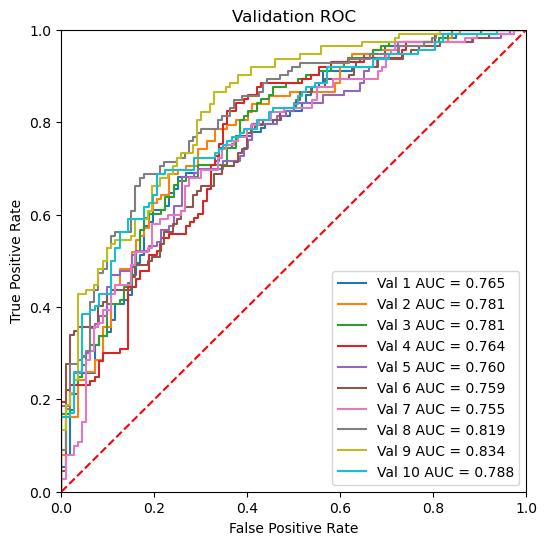

In [45]:
i=1
tprs_val = []
mean_fpr_val = np.linspace(0, 1, 100)
plt.figure(figsize=(6,6))
plt.title('Validation ROC')
for fpr_val,tpr_val,roc_auc_val in zip(fpr_list_val,tpr_list_val,roc_auc_list_val):
    tprs_val.append(np.interp(mean_fpr_val, fpr_val, tpr_val))
    tprs_val[-1][0] = 0.0
    plt.plot(fpr_val, tpr_val, label = 'Val ' + str(i) + ' AUC = %0.3f' % roc_auc_val)
    i+=1
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('CNN_OH_val.png')
plt.show()

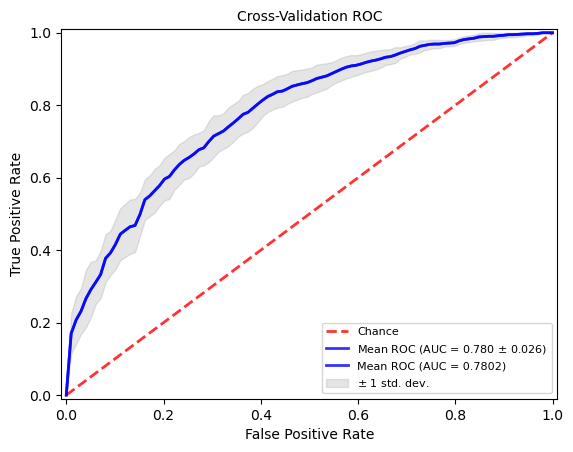

In [46]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr_val = np.mean(tprs_val, axis=0)
mean_tpr_val[-1] = 1.0
mean_auc_val = auc(mean_fpr_val, mean_tpr_val)
std_auc_val = np.std(roc_auc_list_val)
plt.plot(mean_fpr_val, mean_tpr_val, color='b',label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc_val, std_auc_val),lw=2, alpha=.8)
plt.plot(mean_fpr_val, mean_tpr_val, color='b',label=r'Mean ROC (AUC = %0.4f)' % (mean_auc_val),lw=2, alpha=.8)
std_tpr_val = np.std(tprs_val, axis=0)
tprs_upper_val = np.minimum(mean_tpr_val + std_tpr_val, 1)
tprs_lower_val = np.maximum(mean_tpr_val - std_tpr_val, 0)
plt.fill_between(mean_fpr_val, tprs_lower_val, tprs_upper_val, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=10)
plt.ylabel('True Positive Rate',fontsize=10)
plt.title('Cross-Validation ROC',fontsize=10)
plt.legend(loc="lower right", prop={'size': 8})
plt.savefig('CNN_OH_val_mean.png')
plt.show()

In [47]:
def calculate_metrics_val(labels, scores, cutoff=0.5, po_label=1):  # 计算阈值为0.5时的各性能指数
    my_metrics = {  # 先声明建立一个字典，对应KEY值
        'SN': 'NA',
        'SP': 'NA',
        'ACC': 'NA',
        'MCC': 'NA',
        'Recall': 'NA',
        'Precision': 'NA',
        'F1-score': 'NA',
        'Cutoff': cutoff,
    }
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(len(scores)):
        if labels[i] == po_label:  # 如果为正样本
            if scores[i] >= cutoff:  # 阈值为0.5，如果打分大于0.5
                tp = tp + 1  # tp+1  预测为真，实际为真的
            else:
                fn = fn + 1  # 预测为真，实际为负
        else:  # 如果为负样本
            if scores[i] < cutoff:  # 打分小于阈值，说明实际为负，预测也为负
                tn = tn + 1  # tn+1
            else:
                fp = fp + 1  # 打分大于阈值，说明实际为负，预测为正
    my_metrics['SN'] = tp / (tp + fn) if (tp + fn) != 0 else 'NA'  # sn 灵敏度
    my_metrics['SP'] = tn / (fp + tn) if (fp + tn) != 0 else 'NA'  # sp 特异性
    my_metrics['ACC'] = (tp + tn) / (tp + fn + tn + fp)  # acc正确度
    my_metrics['MCC'] = (tp * tn - fp * fn) / np.math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) if ( tp + fp) * ( tp + fn) * ( tn + fp) * ( tn + fn) != 0 else 'NA'
    my_metrics['Precision'] = tp / (tp + fp) if (tp + fp) != 0 else 'NA'  # 查准率
    my_metrics['Recall'] = my_metrics['SN']  # 召回率
    my_metrics['F1-score'] = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) != 0 else 'NA'
    return my_metrics

In [48]:
my_calculate_metrics_list_val = []
for score_val,lable_val in zip(scores_val,lables_val):
    val_my_calculate_metrics = calculate_metrics_val(lable_val,score_val)
    my_calculate_metrics_list_val.append(val_my_calculate_metrics)

In [49]:
my_calculate_metrics_list_val

[{'SN': 0.672566371681416,
  'SP': 0.75,
  'ACC': 0.7111111111111111,
  'MCC': 0.4237735150215389,
  'Recall': 0.672566371681416,
  'Precision': 0.7307692307692307,
  'F1-score': 0.7004608294930875,
  'Cutoff': 0.5},
 {'SN': 0.7678571428571429,
  'SP': 0.6696428571428571,
  'ACC': 0.71875,
  'MCC': 0.43962546169080313,
  'Recall': 0.7678571428571429,
  'Precision': 0.6991869918699187,
  'F1-score': 0.7319148936170212,
  'Cutoff': 0.5},
 {'SN': 0.7079646017699115,
  'SP': 0.6517857142857143,
  'ACC': 0.68,
  'MCC': 0.3603487367343733,
  'Recall': 0.7079646017699115,
  'Precision': 0.6722689075630253,
  'F1-score': 0.6896551724137931,
  'Cutoff': 0.5},
 {'SN': 0.5486725663716814,
  'SP': 0.7857142857142857,
  'ACC': 0.6666666666666666,
  'MCC': 0.34406524078095047,
  'Recall': 0.5486725663716814,
  'Precision': 0.7209302325581395,
  'F1-score': 0.6231155778894473,
  'Cutoff': 0.5},
 {'SN': 0.6371681415929203,
  'SP': 0.7410714285714286,
  'ACC': 0.6888888888888889,
  'MCC': 0.38022762332

In [50]:
performance_val=pd.DataFrame(my_calculate_metrics_list_val)
performance_val

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.672566,0.750000,0.711111,0.423774,0.672566,0.730769,0.700461,0.5
1,0.767857,0.669643,0.718750,0.439625,0.767857,0.699187,0.731915,0.5
2,0.707965,0.651786,0.680000,0.360349,0.707965,0.672269,0.689655,0.5
3,0.548673,0.785714,0.666667,0.344065,0.548673,0.720930,0.623116,0.5
4,0.637168,0.741071,0.688889,0.380228,0.637168,0.712871,0.672897,0.5
5,0.821429,0.522124,0.671111,0.359875,0.821429,0.630137,0.713178,0.5
6,0.821429,0.539823,0.680000,0.376300,0.821429,0.638889,0.718750,0.5
7,0.562500,0.884956,0.724444,0.473041,0.562500,0.828947,0.670213,0.5
8,0.821429,0.681416,0.751111,0.507681,0.821429,0.718750,0.766667,0.5
9,0.589286,0.821429,0.705357,0.422249,0.589286,0.767442,0.666667,0.5


In [51]:
std_val = performance_val.std(axis = 0,ddof=1)
mean_val = performance_val.mean(axis = 0)
data_mean_val = pd.DataFrame(mean_val)
data_mean_val = data_mean_val.T
data_std_val = pd.DataFrame(std_val)
data_std_val = data_std_val.T
performance_val = performance_val.append(data_mean_val)
performance_val = performance_val.append(data_std_val)
performance_val

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.672566,0.750000,0.711111,0.423774,0.672566,0.730769,0.700461,0.5
1,0.767857,0.669643,0.718750,0.439625,0.767857,0.699187,0.731915,0.5
2,0.707965,0.651786,0.680000,0.360349,0.707965,0.672269,0.689655,0.5
3,0.548673,0.785714,0.666667,0.344065,0.548673,0.720930,0.623116,0.5
4,0.637168,0.741071,0.688889,0.380228,0.637168,0.712871,0.672897,0.5
5,0.821429,0.522124,0.671111,0.359875,0.821429,0.630137,0.713178,0.5
6,0.821429,0.539823,0.680000,0.376300,0.821429,0.638889,0.718750,0.5
7,0.562500,0.884956,0.724444,0.473041,0.562500,0.828947,0.670213,0.5
8,0.821429,0.681416,0.751111,0.507681,0.821429,0.718750,0.766667,0.5
9,0.589286,0.821429,0.705357,0.422249,0.589286,0.767442,0.666667,0.5


In [52]:
performance_val.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet\base_data_NEDD_Acet\data_5k\result\CNN_OH_performance_val.csv',encoding='utf-8')

独立测试

In [53]:
#遍历表格求初始里程
#独立测试
import os
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet\base_data_NEDD_Acet\data_5k')
path = r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet\base_data_NEDD_Acet\data_5k\result\indep'
filenames=os.listdir(path)#得到字符串列表
scores_indep=[]
lables_indep=[]
fpr_list_indep = []
tpr_list_indep = []
roc_auc_list_indep=[]
i=0
for filename in filenames:
        true_path=path+r'\\'+filename
        data=pd.read_csv(true_path,engine='python')
        score_indep=data.iloc[:,1]
        scores_indep.append(score_indep)
        lable_indep = data.iloc[:,2]
        lables_indep.append(lable_indep)
        fpr_indep,tpr_indep,thresholds_indep= roc_curve(lables_indep[i],scores_indep[i])   #y_true,y_score
        fpr_list_indep.append(fpr_indep)
        tpr_list_indep.append(tpr_indep)
        roc_auc_indep = auc(fpr_indep,tpr_indep)
        roc_auc_list_indep.append(roc_auc_indep)
        i+=1

In [54]:
roc_auc_list_indep

[0.7923309948979591,
 0.7907366071428572,
 0.7856345663265306,
 0.7810905612244897,
 0.7953603316326531,
 0.7554209183673469,
 0.7561383928571429,
 0.7625956632653061,
 0.7916135204081632,
 0.771843112244898]

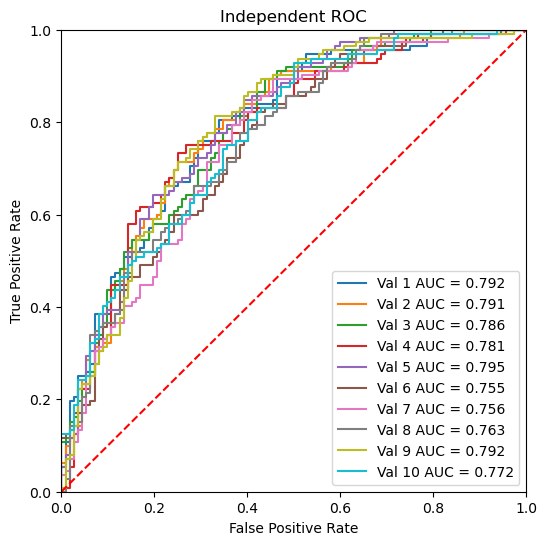

In [55]:
i=1
tprs_indep = []
mean_fpr_indep = np.linspace(0, 1, 100)
plt.figure(figsize=(6,6))
plt.title('Independent ROC')
for fpr_indep,tpr_indep,roc_auc_indep in zip(fpr_list_indep,tpr_list_indep,roc_auc_list_indep):
    tprs_indep.append(np.interp(mean_fpr_indep, fpr_indep, tpr_indep))
    tprs_indep[-1][0] = 0.0
    plt.plot(fpr_indep, tpr_indep, label = 'Val ' + str(i) + ' AUC = %0.3f' % roc_auc_indep)
    i+=1
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('CNN_OH_indep.png')
plt.show()

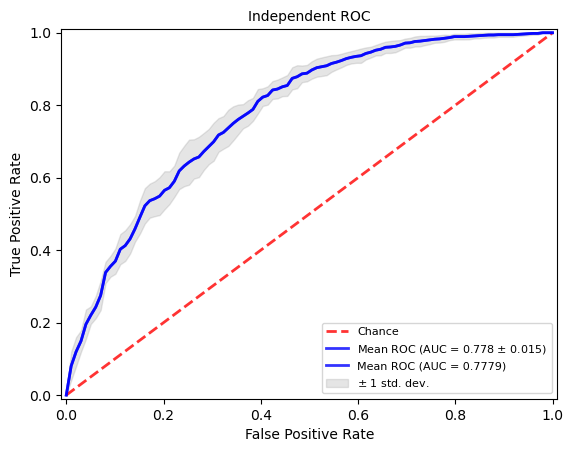

In [56]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr_indep = np.mean(tprs_indep, axis=0)
mean_tpr_indep[-1] = 1.0
mean_auc_indep = auc(mean_fpr_indep, mean_tpr_indep)
std_auc_indep = np.std(roc_auc_list_indep)
plt.plot(mean_fpr_indep, mean_tpr_indep, color='b',label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc_indep, std_auc_indep),lw=2, alpha=.8)
plt.plot(mean_fpr_indep, mean_tpr_indep, color='b',label=r'Mean ROC (AUC = %0.4f)' % (mean_auc_indep),lw=2, alpha=.8)
std_tpr_indep = np.std(tprs_indep, axis=0)
tprs_upper_indep = np.minimum(mean_tpr_indep + std_tpr_indep, 1)
tprs_lower_indep = np.maximum(mean_tpr_indep - std_tpr_indep, 0)
plt.fill_between(mean_fpr_indep, tprs_lower_indep, tprs_upper_indep, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=10)
plt.ylabel('True Positive Rate',fontsize=10)
plt.title('Independent ROC',fontsize=10)
plt.legend(loc="lower right", prop={'size': 8})
plt.savefig('CNN_OH_indep_mean.png')
plt.show()

In [57]:
def calculate_metrics_indep(labels, scores, cutoff=0.5, po_label=1):  # 计算阈值为0.5时的各性能指数
    my_metrics = {  # 先声明建立一个字典，对应KEY值
        'SN': 'NA',
        'SP': 'NA',
        'ACC': 'NA',
        'MCC': 'NA',
        'Recall': 'NA',
        'Precision': 'NA',
        'F1-score': 'NA',
        'Cutoff': cutoff,
    }
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(len(scores)):
        if labels[i] == po_label:  # 如果为正样本
            if scores[i] >= cutoff:  # 阈值为0.5，如果打分大于0.5
                tp = tp + 1  # tp+1  预测为真，实际为真的
            else:
                fn = fn + 1  # 预测为真，实际为负
        else:  # 如果为负样本
            if scores[i] < cutoff:  # 打分小于阈值，说明实际为负，预测也为负
                tn = tn + 1  # tn+1
            else:
                fp = fp + 1  # 打分大于阈值，说明实际为负，预测为正
    my_metrics['SN'] = tp / (tp + fn) if (tp + fn) != 0 else 'NA'  # sn 灵敏度
    my_metrics['SP'] = tn / (fp + tn) if (fp + tn) != 0 else 'NA'  # sp 特异性
    my_metrics['ACC'] = (tp + tn) / (tp + fn + tn + fp)  # acc正确度
    my_metrics['MCC'] = (tp * tn - fp * fn) / np.math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) if ( tp + fp) * ( tp + fn) * ( tn + fp) * ( tn + fn) != 0 else 'NA'
    my_metrics['Precision'] = tp / (tp + fp) if (tp + fp) != 0 else 'NA'  # 查准率
    my_metrics['Recall'] = my_metrics['SN']  # 召回率
    my_metrics['F1-score'] = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) != 0 else 'NA'
    return my_metrics

In [58]:
my_calculate_metrics_list_indep = []
for score_indep,lable_indep in zip(scores_indep,lables_indep):
    indep_my_calculate_metrics = calculate_metrics_indep(lable_indep,score_indep)
    my_calculate_metrics_list_indep.append(indep_my_calculate_metrics)

In [59]:
my_calculate_metrics_list_indep

[{'SN': 0.7053571428571429,
  'SP': 0.7142857142857143,
  'ACC': 0.7098214285714286,
  'MCC': 0.41965958497883704,
  'Recall': 0.7053571428571429,
  'Precision': 0.7117117117117117,
  'F1-score': 0.7085201793721974,
  'Cutoff': 0.5},
 {'SN': 0.7232142857142857,
  'SP': 0.7142857142857143,
  'ACC': 0.71875,
  'MCC': 0.43751743965878753,
  'Recall': 0.7232142857142857,
  'Precision': 0.7168141592920354,
  'F1-score': 0.72,
  'Cutoff': 0.5},
 {'SN': 0.6339285714285714,
  'SP': 0.7410714285714286,
  'ACC': 0.6875,
  'MCC': 0.3771711342562273,
  'Recall': 0.6339285714285714,
  'Precision': 0.71,
  'F1-score': 0.6698113207547169,
  'Cutoff': 0.5},
 {'SN': 0.5446428571428571,
  'SP': 0.8571428571428571,
  'ACC': 0.7008928571428571,
  'MCC': 0.42296894675985147,
  'Recall': 0.5446428571428571,
  'Precision': 0.7922077922077922,
  'F1-score': 0.6455026455026455,
  'Cutoff': 0.5},
 {'SN': 0.6875,
  'SP': 0.7232142857142857,
  'ACC': 0.7053571428571429,
  'MCC': 0.41097647168782137,
  'Recall': 0

In [60]:
performance_indep=pd.DataFrame(my_calculate_metrics_list_indep)
performance_indep

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.705357,0.714286,0.709821,0.419660,0.705357,0.711712,0.708520,0.5
1,0.723214,0.714286,0.718750,0.437517,0.723214,0.716814,0.720000,0.5
2,0.633929,0.741071,0.687500,0.377171,0.633929,0.710000,0.669811,0.5
3,0.544643,0.857143,0.700893,0.422969,0.544643,0.792208,0.645503,0.5
4,0.687500,0.723214,0.705357,0.410976,0.687500,0.712963,0.700000,0.5
5,0.839286,0.544643,0.691964,0.401764,0.839286,0.648276,0.731518,0.5
6,0.803571,0.616071,0.709821,0.427220,0.803571,0.676692,0.734694,0.5
7,0.571429,0.767857,0.669643,0.346027,0.571429,0.711111,0.633663,0.5
8,0.758929,0.696429,0.727679,0.456249,0.758929,0.714286,0.735931,0.5
9,0.526786,0.794643,0.660714,0.333619,0.526786,0.719512,0.608247,0.5


In [61]:
std_indep = performance_indep.std(axis = 0,ddof=1)
mean_indep = performance_indep.mean(axis = 0)
data_mean_indep = pd.DataFrame(mean_indep)
data_mean_indep = data_mean_indep.T
data_std_indep = pd.DataFrame(std_indep)
data_std_indep = data_std_indep.T
performance_indep = performance_indep.append(data_mean_indep)
performance_indep = performance_indep.append(data_std_indep)
performance_indep

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.705357,0.714286,0.709821,0.419660,0.705357,0.711712,0.708520,0.5
1,0.723214,0.714286,0.718750,0.437517,0.723214,0.716814,0.720000,0.5
2,0.633929,0.741071,0.687500,0.377171,0.633929,0.710000,0.669811,0.5
3,0.544643,0.857143,0.700893,0.422969,0.544643,0.792208,0.645503,0.5
4,0.687500,0.723214,0.705357,0.410976,0.687500,0.712963,0.700000,0.5
5,0.839286,0.544643,0.691964,0.401764,0.839286,0.648276,0.731518,0.5
6,0.803571,0.616071,0.709821,0.427220,0.803571,0.676692,0.734694,0.5
7,0.571429,0.767857,0.669643,0.346027,0.571429,0.711111,0.633663,0.5
8,0.758929,0.696429,0.727679,0.456249,0.758929,0.714286,0.735931,0.5
9,0.526786,0.794643,0.660714,0.333619,0.526786,0.719512,0.608247,0.5


In [62]:
performance_indep.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet\base_data_NEDD_Acet\data_5k\result\CNN_OH_performance_indep.csv',encoding='utf-8')

In [63]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

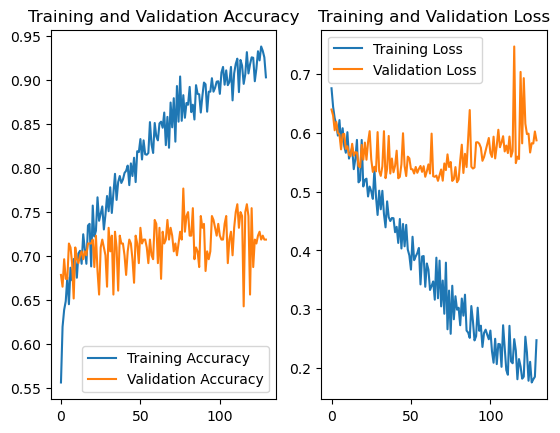

In [64]:
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()